## Capstone project: Classification

### The data

The dataset represents PCB design projects data collected from various places and periods of time. 
The dataset contains 345 entries and 19 features. The dataset is complete with no missing values and has both numerical and categorical data.
The features include physical characteristics of the boards designed, plus a number of descriptive characteristics.


Features description:

Numerical:
* ID - automatically assigned ID number 
* viano - number of vias
* pins - number of pins
* layno - number of layers
* sq - layout area
* dens - layout density
* netno - number of nets
* comp - number of components
* duration - layout design duration
* level - engineer expertise level

Categorical:

* line -  product line (various)
* fit - board utilization (such as daughter board, mlb, etc.)
* viatech - via technology (tht, combinations, etc.)
* dbl - single or double sided
* category - board tech, rigid or flexible
* ver - board version
* complexity - board complexity (low, medium or high)
* scope - scope of the design (new board, minor or major modification)
* type - board family type (such as test, production, etc.)

### Business understanding

Usually a project complexity is estimated by the engineers or the managers who are directly involved in the design, based on objective and subjective factors such as personal experience. A tool which uses only projects' features and eliminates the subjective factors, and which consistently provides good classifications, would considerably improve the resource planning and projects' assignment. The tool can also learn along and the data can improve as a result of the feature importance results.

The classification of a project based on physical and descriptive characteristics of the project can improve the management understading of the tasks and can indicate the type of resources needed to be used. For example a low complexity project can be designed by a more junior engineer, while the very complex ones require some more experience. A classification tool can help team leaders to assign projects more accurately.

##### Important observation
The classification is needed and happens before the design starts when only a part of the features are available. Thus, some of the features will be discarded. 

### What is the data task here?
1. Can I use the available data to build a classifier tool that can help predicting the complexity of a project?
2. What data can be ignored, or dropped from the analysis?
3. Do I need to clean up the data and how do I prepare the data?
4. What are the top features that influence the classification?
5. Is the model accurate enough? What is missing, how can I improve the data set and the analysis as next steps?

### Data understanding

Getting familiar with the data and identifying quality issues. 

In [1]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, roc_curve
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn import set_config
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
set_config(display="diagram")
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")
from sklearn.dummy import DummyClassifier
from sklearn.metrics import RocCurveDisplay

from sklearn.datasets import load_digits
from sklearn import datasets, metrics
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

In [2]:
df = pd.read_csv('projects_wrk3663.csv')
df = df.drop(columns = ['ID'])
df = df.dropna()
df

,line,fit,viatech,viano,pins,layno,sq,dens,dbl,netno,comp,category,ver,complexity,scope,type,duration,level
0,bis,sns,tht,4,20,2,0.21,0.148,dbl,4,6,RG,R2,Medium,MOD-MINOR,FF,73,5
1,ced,mlb,astk,85589,5574,12,71.57,0.180,dbl,728,1454,RG,B0,High,NEW BRD,FF,119,5
2,tgr,mlb,astk,90198,5943,12,80.28,0.189,dbl,814,1541,RG,E0,Medium,MOD-MAJOR,FF,68,5
3,tgr,mlb,astk,62689,5792,12,80.87,0.195,dbl,813,1403,RG,R2,High,MOD-MAJOR,FF,44,5
4,tgr,mlb,astk,63178,5792,12,80.87,0.195,dbl,813,1403,RG,B1,High,MOD-MAJOR,FF,71,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,tgr,bb,tht,167,18,2,14.42,11.210,dbl,4,11,FP,B1,Low,MOD-MINOR,FF,36,5
341,tgr,bb,tht,264,18,2,14.58,11.340,dbl,4,11,FP,R2,Low,MOD-MINOR,FF,53,5
342,tgr,bb,tht,264,18,2,14.58,11.342,dbl,4,11,FP,E0,Medium,MOD-MINOR,FF,26,5
343,src,db,tht,1065,32,2,145.78,10.770,dbl,17,9,RG,DE,Low,NEW BRD,TSB,3,5


#### Observations: 
This is a classification problem where the label is "complexity". In the original data the label has three values, but we are interested only in a binary label, "complexity" = 'low' or 'high'.
The following physical characteristics are not available before the start of the design:
- 'viano', 'pins', 'sq', 'dens', 'netno' have meaning only after the design is completed, extracted from the design
- 'level' is the engineer experience and it is a result of the classification (project assignment)
- 'duration' has a value only after the design is completed

In [3]:
# dropping the unused columns 
df = df.drop(columns = ['viano', 'pins', 'sq', 'dens', 'netno', 'level', 'duration'])
df

,line,fit,viatech,layno,dbl,comp,category,ver,complexity,scope,type
0,bis,sns,tht,2,dbl,6,RG,R2,Medium,MOD-MINOR,FF
1,ced,mlb,astk,12,dbl,1454,RG,B0,High,NEW BRD,FF
2,tgr,mlb,astk,12,dbl,1541,RG,E0,Medium,MOD-MAJOR,FF
3,tgr,mlb,astk,12,dbl,1403,RG,R2,High,MOD-MAJOR,FF
4,tgr,mlb,astk,12,dbl,1403,RG,B1,High,MOD-MAJOR,FF
...,...,...,...,...,...,...,...,...,...,...,...
340,tgr,bb,tht,2,dbl,11,FP,B1,Low,MOD-MINOR,FF
341,tgr,bb,tht,2,dbl,11,FP,R2,Low,MOD-MINOR,FF
342,tgr,bb,tht,2,dbl,11,FP,E0,Medium,MOD-MINOR,FF
343,src,db,tht,2,dbl,9,RG,DE,Low,NEW BRD,TSB


Making the label binary, by replacing 'Medium' with 'High'

In [4]:
# reducing to a binary label
df['complexity'] = df['complexity'].str.replace('Medium','High')

In [5]:
df['complexity'].value_counts()

High    186
Low     159
Name: complexity, dtype: int64

<AxesSubplot:xlabel='complexity', ylabel='count'>

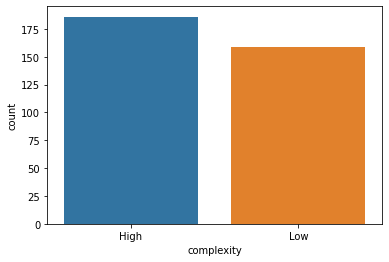

In [6]:
# visual representation of the label
sns.countplot(df['complexity'])

Observation:  The two classes are well balanced

In [7]:
# dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   line        345 non-null    object
 1   fit         345 non-null    object
 2   viatech     345 non-null    object
 3   layno       345 non-null    int64 
 4   dbl         345 non-null    object
 5   comp        345 non-null    int64 
 6   category    345 non-null    object
 7   ver         345 non-null    object
 8   complexity  345 non-null    object
 9   scope       345 non-null    object
 10  type        345 non-null    object
dtypes: int64(2), object(9)
memory usage: 29.8+ KB


Looking at the features

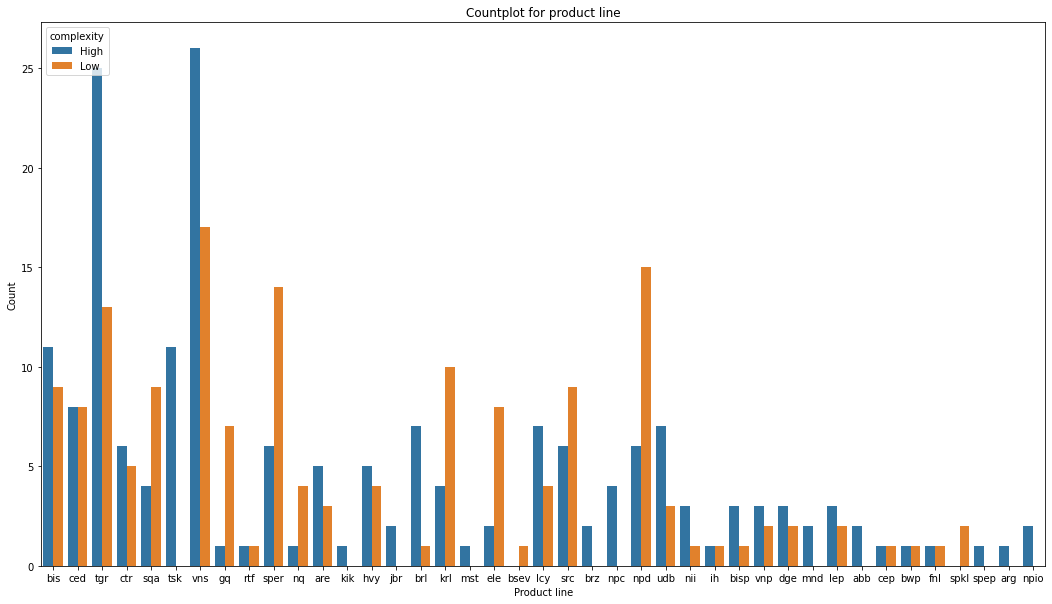

In [8]:
# countplot line
plt.figure(figsize=(18, 10))
sns.countplot(df['line'], hue = df['complexity'])
plt.xlabel('Product line')
plt.ylabel('Count')
plt.title('Countplot for product line');

Observation: There is a reasonable distribution of the  complexity across the programs

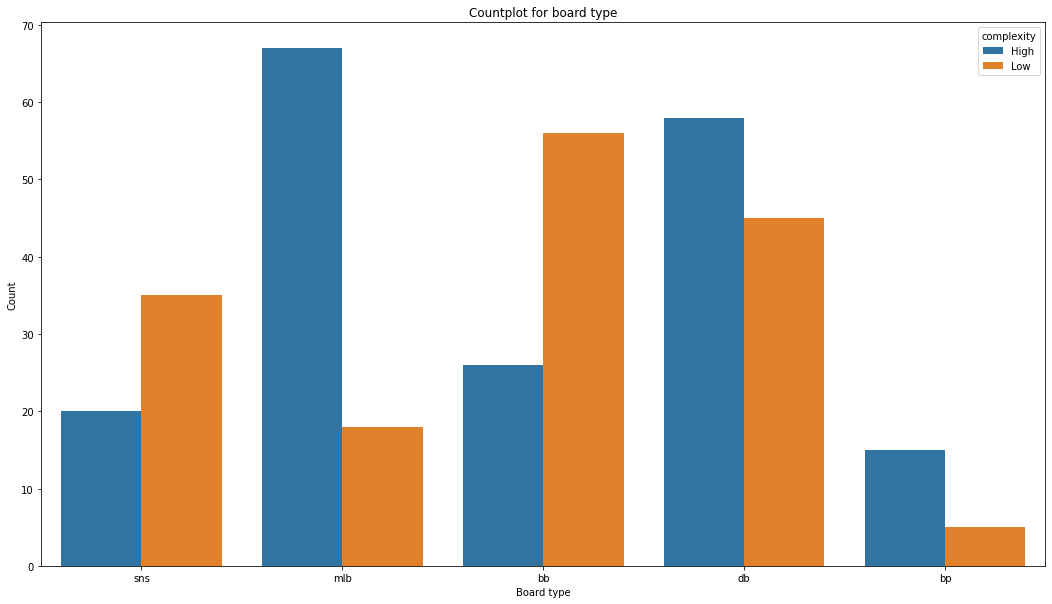

In [9]:
# countplot fit
plt.figure(figsize=(18, 10))
sns.countplot(df['fit'], hue = df['complexity'])
plt.xlabel('Board type')
plt.ylabel('Count')
plt.title('Countplot for board type');

Observation: the graph reflects the relation between the complexity and the type of board, for example the majority of the mlb's are high complexity

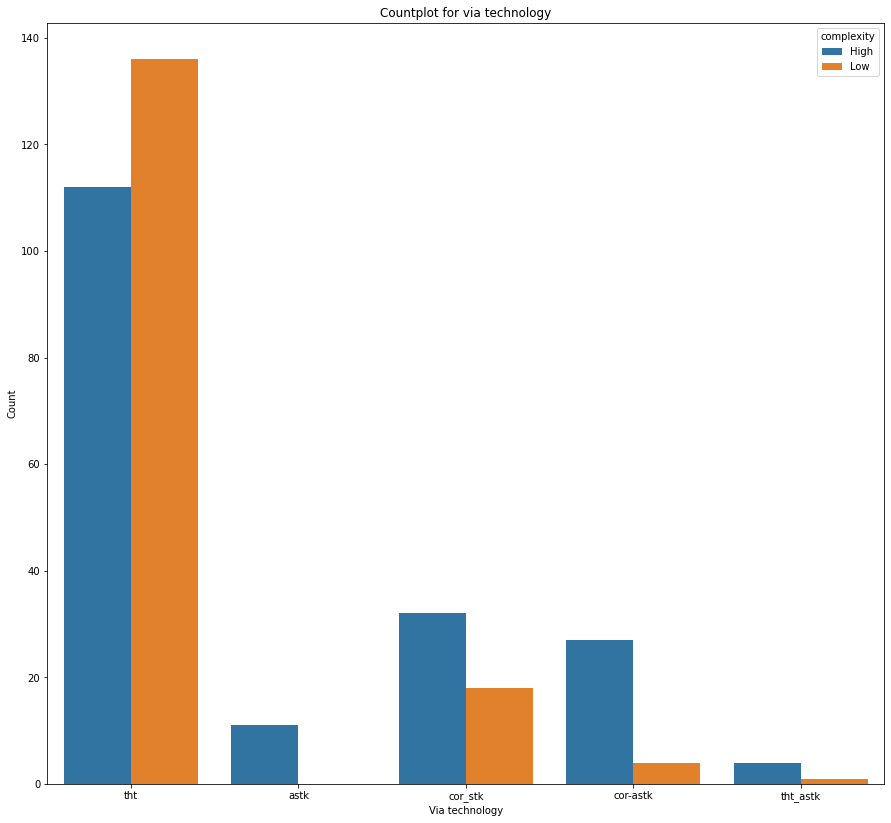

In [10]:
# countplot via technology
plt.figure(figsize=(15, 14))
sns.countplot(df['viatech'], hue = df['complexity'])
plt.xlabel('Via technology')
plt.ylabel('Count')
plt.title('Countplot for via technology');

Observation: the designs including a specific stacked ('stk') technology are more complex

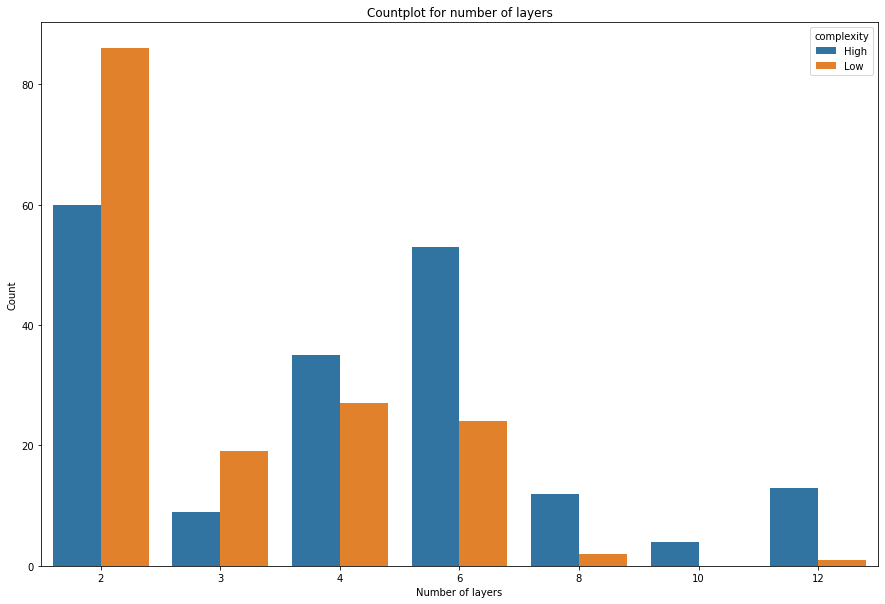

In [11]:
# countplot layers
plt.figure(figsize=(15, 10))
sns.countplot(df['layno'], hue = df['complexity'])
plt.xlabel('Number of layers')
plt.ylabel('Count')
plt.title('Countplot for number of layers');

Observation: 4, 6, 8, 10 and 12 layers tend to be more complex, as expected.

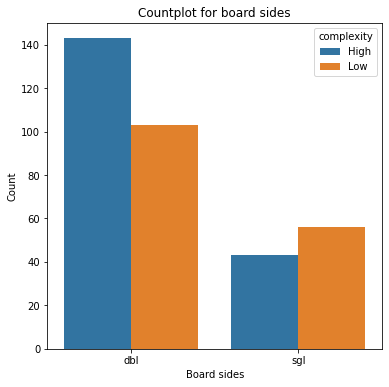

In [12]:
# countplot single/double
plt.figure(figsize=(6, 6))
sns.countplot(df['dbl'], hue = df['complexity'])
plt.xlabel('Board sides')
plt.ylabel('Count')
plt.title('Countplot for board sides');

Observation: double sided boards are more complex

In [13]:
len(df['comp'].unique())

179

Since there are so many distinct values, it might be a good idea to group in a few categories and encode

In [14]:
df.loc[df['comp'] <= 20, 'comp'] = 1
df.loc[(df['comp'] > 20) & (df['comp'] <= 80), 'comp'] = 2
df.loc[(df['comp'] > 80) & (df['comp'] <= 250), 'comp'] = 3
df.loc[(df['comp'] > 250) & (df['comp'] <= 700), 'comp'] = 4
df.loc[(df['comp'] > 700) & (df['comp'] <= 1200), 'comp'] = 5
df.loc[df['comp'] > 1200, 'comp'] = 6

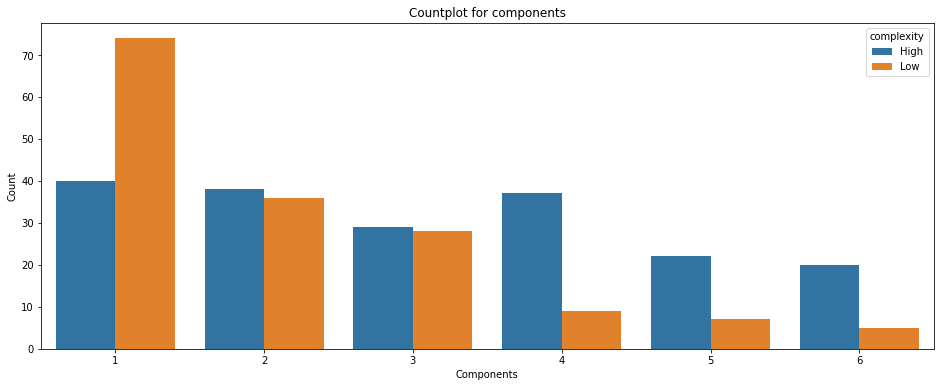

In [15]:
# countplot components
plt.figure(figsize=(16, 6))
sns.countplot(df['comp'], hue = df['complexity'])
plt.xlabel('Components')
plt.ylabel('Count')
plt.title('Countplot for components');

Observation: As expected, the more components on the board, the more complex the design is

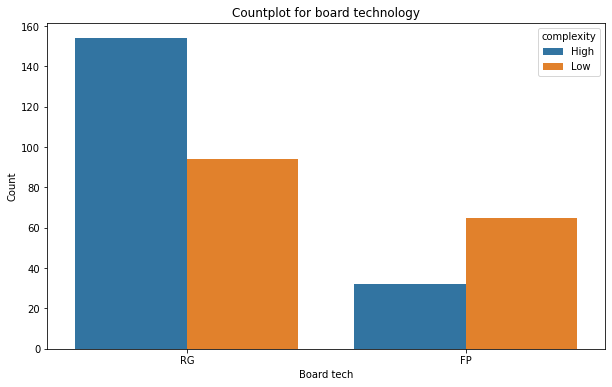

In [16]:
# countplot category
plt.figure(figsize=(10, 6))
sns.countplot(df['category'], hue = df['complexity'])
plt.xlabel('Board tech')
plt.ylabel('Count')
plt.title('Countplot for board technology');

Observation: rigid boards are more complex than the flexible boards

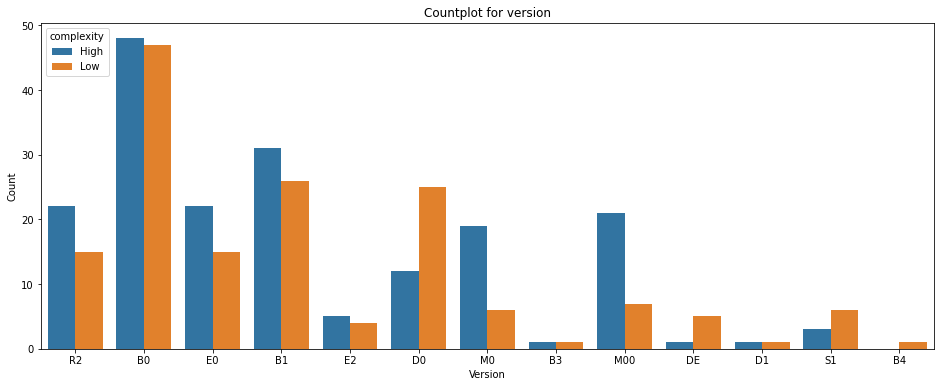

In [17]:
# countplot version
plt.figure(figsize=(16, 6))
sns.countplot(df['ver'], hue = df['complexity'])
plt.xlabel('Version')
plt.ylabel('Count')
plt.title('Countplot for version');

Observation: as expected, M00, M0 (new designs) tend to be most complex

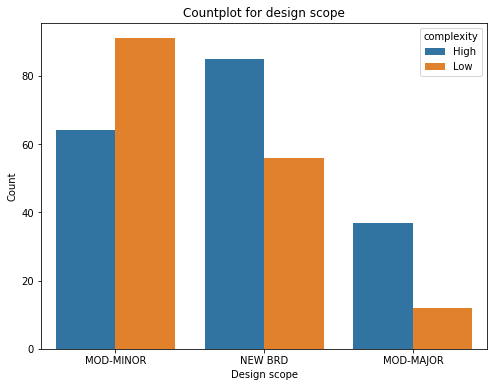

In [18]:
# countplot scope
plt.figure(figsize=(8, 6))
sns.countplot(df['scope'], hue = df['complexity'])
plt.xlabel('Design scope')
plt.ylabel('Count')
plt.title('Countplot for design scope');

Observation: new designs and major modifications are mostly complex

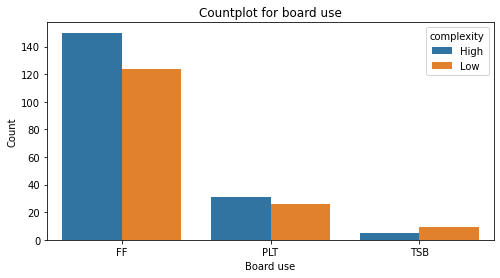

In [19]:
# countplot type
plt.figure(figsize=(8, 4))
sns.countplot(df['type'], hue = df['complexity'])
plt.xlabel('Board use')
plt.ylabel('Count')
plt.title('Countplot for board use');

Observation: balanced in the three categories

The features of type object will be encoded using OneHotEncoder

### The capstone project objective: 
Find the best model that can tell whether a project is of high or low complexity. I will do this by comparing the performance of the classifiers K-Nearest Neighbors, Logistic Regression, Decision Trees, and Support Vector Machines. I will also try to extract which of the features contribute to the classification the most. 

### Engineering features
Reload the dataset and keep the 'comp' as discrete values (the grouping was useful for the graph)

In [20]:
df = pd.read_csv('projects_wrk3663.csv')
df = df.drop(columns = ['ID', 'viano', 'pins', 'sq', 'dens', 'netno', 'level', 'duration'])
df = df.dropna()
# reducing to a binary label
df['complexity'] = df['complexity'].str.replace('Medium','High')
df

,line,fit,viatech,layno,dbl,comp,category,ver,complexity,scope,type
0,bis,sns,tht,2,dbl,6,RG,R2,High,MOD-MINOR,FF
1,ced,mlb,astk,12,dbl,1454,RG,B0,High,NEW BRD,FF
2,tgr,mlb,astk,12,dbl,1541,RG,E0,High,MOD-MAJOR,FF
3,tgr,mlb,astk,12,dbl,1403,RG,R2,High,MOD-MAJOR,FF
4,tgr,mlb,astk,12,dbl,1403,RG,B1,High,MOD-MAJOR,FF
...,...,...,...,...,...,...,...,...,...,...,...
340,tgr,bb,tht,2,dbl,11,FP,B1,Low,MOD-MINOR,FF
341,tgr,bb,tht,2,dbl,11,FP,R2,Low,MOD-MINOR,FF
342,tgr,bb,tht,2,dbl,11,FP,E0,High,MOD-MINOR,FF
343,src,db,tht,2,dbl,9,RG,DE,Low,NEW BRD,TSB


Encode the data

In [21]:
# create the feature categories
col_ohe = ['dbl', 'category','scope', 'type','line', 'fit', 'viatech', 'ver']
#col_bin = ['line', 'fit', 'viatech', 'ver']
col_std = ['layno','comp']

In [22]:
# create a column transformer
col_transformer = ColumnTransformer([('ohe', OneHotEncoder(drop="if_binary"), col_ohe),
                                    ('std', StandardScaler(), col_std)],
                            remainder = 'passthrough')
# will apply the transformer to the train and test sets

### Train / Test split

In [23]:
# define X and y
X = df.drop('complexity', axis = 1)
y = df['complexity']

In [24]:
# split the data in initial non transformed data
Xi_train, Xi_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

In [25]:
# transform the data
X_train = col_transformer.fit_transform(Xi_train)
X_test = col_transformer.transform(Xi_test)

In [26]:
# inspect y_train and y_test
print(y_train.value_counts())
print(y_test.value_counts())

High    143
Low     133
Name: complexity, dtype: int64
High    43
Low     26
Name: complexity, dtype: int64


### Baseline model

In [27]:
# use a DummyClassifier with the training data and score the estimator
dummy_clf = DummyClassifier()
start = time.time()
dummy_clf.fit(X_train, y_train)
stop = time.time()

Fit time is: 0.6039142608642578 ms

Dummy model score is: 0.6231884057971014 

Classification report for classifier DummyClassifier():
              precision    recall  f1-score   support

        High       0.62      1.00      0.77        43
         Low       0.00      0.00      0.00        26

    accuracy                           0.62        69
   macro avg       0.31      0.50      0.38        69
weighted avg       0.39      0.62      0.48        69




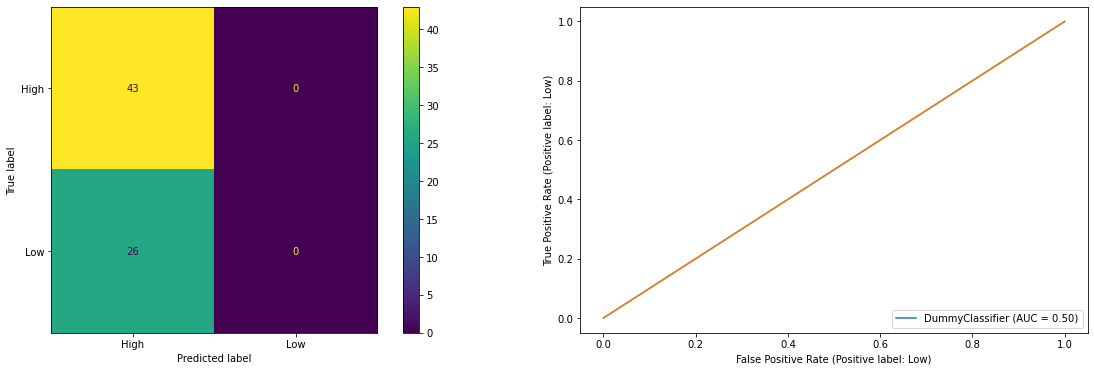

In [28]:
# print the fit time and the score
print('Fit time is:',(stop-start)*1000,'ms\n')
print('Dummy model score is:', dummy_clf.score(X_test, y_test),'\n')
print(
    f"Classification report for classifier {dummy_clf}:\n"
    f"{metrics.classification_report(y_test, dummy_clf.predict(X_test))}\n");

#print the confusion matrix and the ROC curve
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(dummy_clf, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(dummy_clf, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]));

Observation: The dummy model is giving an AUC of 0.5 and as visible from the confusion matrix the model cannot classify the 'low' label. 

### Simple Logistic Regression model

In [29]:
# build a basic default Logistic Regression model, fit on train data
lgr_def = LogisticRegression()
start_l_d = time.time()
lgr_def.fit(X_train, y_train)
stop_l_d = time.time()
t_lgr_def = (stop_l_d-start_l_d)*1000
lgr_def_acc_tr = accuracy_score(y_train, lgr_def.predict(X_train))
lgr_def_acc_ts = accuracy_score(y_test, lgr_def.predict(X_test))
print('Train accuracy score for default LogisticRegression model:', lgr_def_acc_tr)
print('Test accuracy score for default LogisticRegression model:', lgr_def_acc_ts)

Train accuracy score for default LogisticRegression model: 0.822463768115942
Test accuracy score for default LogisticRegression model: 0.6521739130434783


Fit time is: 0.6039142608642578 ms

Logistic Regression Basic score is: 0.6521739130434783 

Classification report for classifier LogisticRegression():
              precision    recall  f1-score   support

        High       0.81      0.58      0.68        43
         Low       0.53      0.77      0.62        26

    accuracy                           0.65        69
   macro avg       0.67      0.68      0.65        69
weighted avg       0.70      0.65      0.66        69




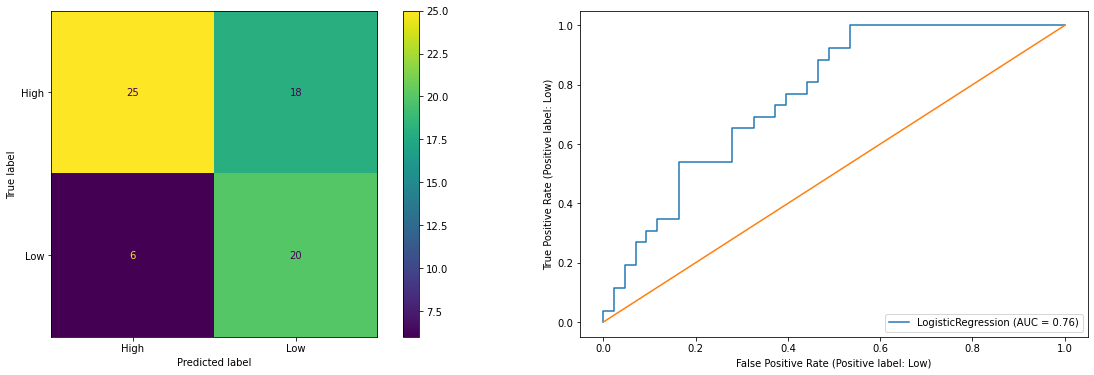

In [30]:
# print the LogisticRegression score and the classification report and the Confusion Matrix and ROC curve
print('Fit time is:',(stop-start)*1000,'ms\n')
print('Logistic Regression Basic score is:', lgr_def.score(X_test, y_test),'\n')
print(
    f"Classification report for classifier {lgr_def}:\n"
    f"{metrics.classification_report(y_test, lgr_def.predict(X_test))}\n");

#print the confusion matrix and the ROC curve
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(lgr_def, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(lgr_def, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]));

Observation: reasonable AUC and confusion matrix. The model can predict both labels. 

### Other models:
KNN, Decision Tree, SVC models with default settings

In [31]:
# build a KNN model with default settings and find the accuracy score for train and test
knn_def = KNeighborsClassifier()
start_k_d = time.time()
knn_def.fit(X_train, y_train)
stop_k_d = time.time()
t_knn_def = (stop_k_d-start_k_d)*1000
knn_def_acc_tr = accuracy_score(y_train, knn_def.predict(X_train))
knn_def_acc_ts = accuracy_score(y_test, knn_def.predict(X_test))
print('Train accuracy score for default KNN model:', knn_def_acc_tr)
print('Test accuracy score for default KNN model:', knn_def_acc_ts)

Train accuracy score for default KNN model: 0.8260869565217391
Test accuracy score for default KNN model: 0.5942028985507246


In [32]:
# build a Decision Tree model with default settings and find the accuracy score for train and test
dtr_def = DecisionTreeClassifier()
start_d_d = time.time()
dtr_def.fit(X_train, y_train)
stop_d_d = time.time()
t_dtr_def = (stop_d_d-start_d_d)*1000
dtr_def_acc_tr = accuracy_score(y_train, dtr_def.predict(X_train))
dtr_def_acc_ts = accuracy_score(y_test, dtr_def.predict(X_test))
print('Train accuracy score for default DecisionTree model:', dtr_def_acc_tr)
print('Test accuracy score for default DecisionTree model:', dtr_def_acc_ts)

Train accuracy score for default DecisionTree model: 0.9927536231884058
Test accuracy score for default DecisionTree model: 0.7391304347826086


In [33]:
# build a SVC model with default settings and find the accuracy score for train and test
svc_def = SVC()
start_s_d = time.time()
svc_def.fit(X_train, y_train)
stop_s_d = time.time()
t_svc_def = (stop_s_d-start_s_d)*1000
svc_def_acc_tr = accuracy_score(y_train, svc_def.predict(X_train))
svc_def_acc_ts = accuracy_score(y_test, svc_def.predict(X_test))
print('Train accuracy score for default SVC model:', svc_def_acc_tr)
print('Test accuracy score for default SVC model:', svc_def_acc_ts)

Train accuracy score for default SVC model: 0.8695652173913043
Test accuracy score for default SVC model: 0.6956521739130435


In [34]:
# putting the results in a comparison table
data_def = {'Model': ['Logistic Regression', 'KNN','Decision Tree', 'SVM'],
            'Train Time(ms)': [t_lgr_def, t_knn_def, t_dtr_def, t_svc_def],
            'Train Accuracy': [lgr_def_acc_tr, knn_def_acc_tr, dtr_def_acc_tr, svc_def_acc_tr],
            'Test Accuracy': [lgr_def_acc_ts, knn_def_acc_ts, dtr_def_acc_ts, svc_def_acc_ts],}
summary_df = pd.DataFrame(data_def).set_index('Model')
print('\033[1m  Comparison Table for default models')
summary_df

  Comparison Table for default models


,Train Time(ms),Train Accuracy,Test Accuracy
Model,,,
Logistic Regression,29.328823,0.822464,0.652174
KNN,1.459122,0.826087,0.594203
Decision Tree,4.930973,0.992754,0.739130
SVM,13.483047,0.869565,0.695652


#### Printing the Confusion Matrix and the ROC curve and the classification report

KNN default score is: 0.5942028985507246 

Classification report for classifier KNeighborsClassifier():
              precision    recall  f1-score   support

        High       0.71      0.58      0.64        43
         Low       0.47      0.62      0.53        26

    accuracy                           0.59        69
   macro avg       0.59      0.60      0.59        69
weighted avg       0.62      0.59      0.60        69




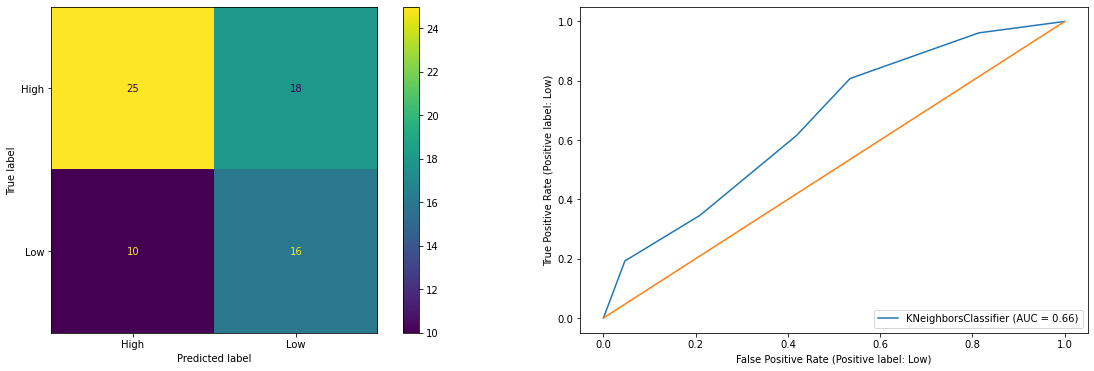

In [35]:
# print the KNN default score and the classification report
print('KNN default score is:', knn_def.score(X_test, y_test),'\n')
print(
    f"Classification report for classifier {knn_def}:\n"
    f"{metrics.classification_report(y_test, knn_def.predict(X_test))}\n");

#print the confusion matrix and the ROC curve
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(knn_def, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(knn_def, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]));

Decision Tree default score is: 0.7391304347826086 

Classification report for classifier DecisionTreeClassifier():
              precision    recall  f1-score   support

        High       0.82      0.74      0.78        43
         Low       0.63      0.73      0.68        26

    accuracy                           0.74        69
   macro avg       0.73      0.74      0.73        69
weighted avg       0.75      0.74      0.74        69




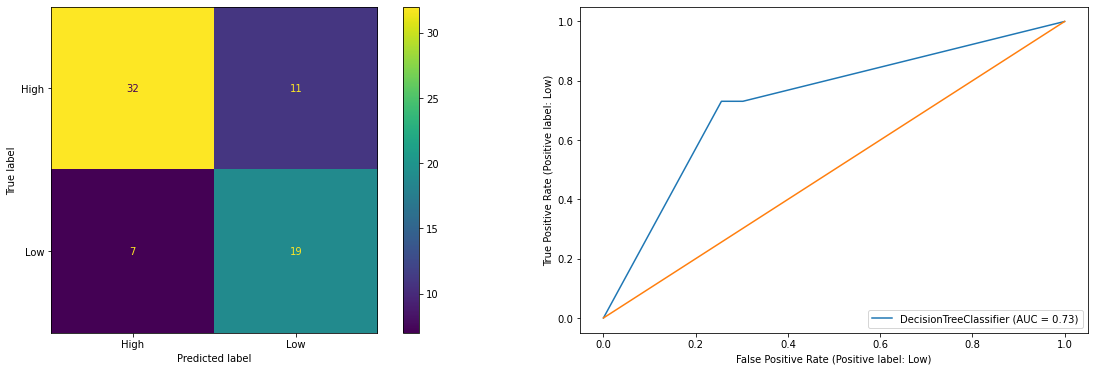

In [36]:
# print the DecisionTree score and the classification report
print('Decision Tree default score is:', dtr_def.score(X_test, y_test),'\n')
print(
    f"Classification report for classifier {dtr_def}:\n"
    f"{metrics.classification_report(y_test, dtr_def.predict(X_test))}\n");

#print the confusion matrix and the ROC curve
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(dtr_def, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(dtr_def, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]));

SVC default score is: 0.6956521739130435 

Classification report for classifier SVC():
              precision    recall  f1-score   support

        High       0.84      0.63      0.72        43
         Low       0.57      0.81      0.67        26

    accuracy                           0.70        69
   macro avg       0.71      0.72      0.69        69
weighted avg       0.74      0.70      0.70        69




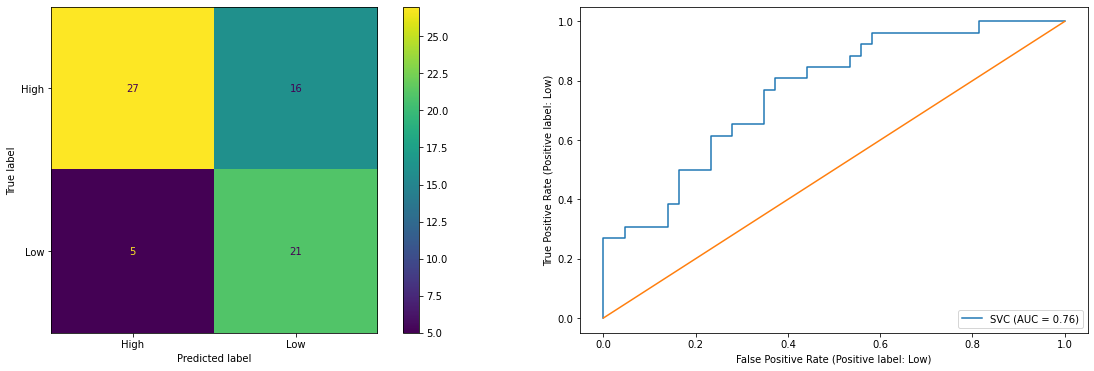

In [37]:
# print the SVC score and the classification report
print('SVC default score is:', svc_def.score(X_test, y_test),'\n')
print(
    f"Classification report for classifier {svc_def}:\n"
    f"{metrics.classification_report(y_test, svc_def.predict(X_test))}\n");

#print the confusion matrix and the ROC curve
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(svc_def, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(svc_def, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]));

Observation: SVC is the best model so far, with AUC = 0.82

### Improving the models
#### Hyperparameter tuning and grid search

In [38]:
# Logistic Regression grid
lgr = LogisticRegression()
params_lgr = {'C':np.logspace(-5, .5),
            'solver': ['lbfgs', 'liblinear'],
             'penalty' : ['l1','l2']}
grid_lgr = GridSearchCV(lgr, param_grid = params_lgr,
                   scoring = 'roc_auc').fit(X_train, y_train)
lgr_score = grid_lgr.score(X_test, y_test)
time_lgr = round((grid_lgr.cv_results_['mean_fit_time'].sum())*1000, 3)
lgr_par = grid_lgr.best_params_
print('lgr score is:', lgr_score)
print('fit time lgr is:',time_lgr)
print('lgr parameters:', lgr_par)

lgr score is: 0.7620751341681573
fit time lgr is: 557.509
lgr parameters: {'C': 0.30888435964774785, 'penalty': 'l2', 'solver': 'lbfgs'}


In [39]:
# KNN grid
knn = KNeighborsClassifier()
params_knn = {'n_neighbors':range(1, 20, 2)}
grid_knn = GridSearchCV(knn, param_grid = params_knn,
                   scoring = 'roc_auc').fit(X_train, y_train)
knn_score = grid_knn.score(X_test, y_test)
time_knn = round((grid_knn.cv_results_['mean_fit_time'].sum())*1000, 3)
knn_par = grid_knn.best_params_
print('knn score is:', knn_score)
print('fit time knn is:',time_knn)
print('knn parameters:', knn_par)

knn score is: 0.6610017889087656
fit time knn is: 15.84
knn parameters: {'n_neighbors': 5}


In [40]:
# Decision Tree grid
dtr = DecisionTreeClassifier()
params_dtr = {'max_depth': [None, 3000, 50, 45, 30, 20, 10, 5, 3, 1],
         'min_samples_split': [2, 5, 10],
          'criterion': ['gini', 'entropy'],
          'min_samples_leaf': [1, 2, 3, 4]
             }
grid_dtr = GridSearchCV(dtr, param_grid = params_dtr,
                   scoring = 'roc_auc').fit(X_train, y_train)
dtr_score = grid_dtr.score(X_test, y_test)
time_dtr = round((grid_dtr.cv_results_['mean_fit_time'].sum())*1000, 3)
dtr_par = grid_dtr.best_params_
print('dtr score is:', dtr_score)
print('fit time dtr is:',time_dtr)
print('dtr parameters:', dtr_par)

dtr score is: 0.7607334525939178
fit time dtr is: 513.708
dtr parameters: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [41]:
# SVC grid
svc = SVC()
params_svc = {'kernel': ['rbf','sigmoid'],'gamma': [0.1, 1.0, 10.0, 100.0]}
grid_svc = GridSearchCV(svc, param_grid = params_svc,
                   scoring = 'roc_auc').fit(X_train, y_train)
svc_score = grid_svc.score(X_test, y_test)
time_svc = round((grid_svc.cv_results_['mean_fit_time'].sum())*1000, 3)
svc_par = grid_svc.best_params_
print('svc score is:', svc_score)
print('fit time svc is:',time_svc)
print('svc parameters:', svc_par)

svc score is: 0.7719141323792487
fit time svc is: 42.81
svc parameters: {'gamma': 0.1, 'kernel': 'rbf'}


In [42]:
# Tuned Linear Regression
lgr_tun = LogisticRegression(C= lgr_par['C'], penalty= lgr_par['penalty'], solver= lgr_par['solver'])
start_l_t = time.time()
lgr_tun.fit(X_train, y_train)
stop_l_t = time.time()
t_lgr_tun = (stop_l_t-start_l_t)*1000
lgr_tun_acc_tr = accuracy_score(y_train, lgr_tun.predict(X_train))
lgr_tun_acc_ts = accuracy_score(y_test, lgr_tun.predict(X_test))
print('Train accuracy score for tuned LogisticRegression model:', lgr_tun_acc_tr)
print('Test accuracy score for tuned LogisticRegression model:', lgr_tun_acc_ts)

Train accuracy score for tuned LogisticRegression model: 0.8152173913043478
Test accuracy score for tuned LogisticRegression model: 0.6521739130434783


In [43]:
# Tuned KNN 
knn_tun = KNeighborsClassifier(n_neighbors = knn_par['n_neighbors'])
start_k_t = time.time()
knn_tun.fit(X_train, y_train)
stop_k_t = time.time()
t_knn_tun = (stop_k_t-start_k_t)*1000
knn_tun_acc_tr = accuracy_score(y_train, knn_tun.predict(X_train))
knn_tun_acc_ts = accuracy_score(y_test, knn_tun.predict(X_test))
print('Train accuracy score for tuned KNN model:', knn_tun_acc_tr)
print('Test accuracy score for tuned KNN model:', knn_tun_acc_ts)

Train accuracy score for tuned KNN model: 0.8260869565217391
Test accuracy score for tuned KNN model: 0.5942028985507246


In [44]:
# Tuned Decision Tree
dtr_tun = DecisionTreeClassifier(criterion= dtr_par['criterion'], 
                                 max_depth= dtr_par['max_depth'], 
                                 min_samples_leaf= dtr_par['min_samples_leaf'], 
                                 min_samples_split= dtr_par['min_samples_split'])
start_d_t = time.time()
dtr_tun.fit(X_train, y_train)
stop_d_t = time.time()
t_dtr_tun = (stop_d_t-start_d_t)*1000
dtr_tun_acc_tr = accuracy_score(y_train, dtr_tun.predict(X_train))
dtr_tun_acc_ts = accuracy_score(y_test, dtr_tun.predict(X_test))
print('Train accuracy score for tuned DecisionTree model:', dtr_tun_acc_tr)
print('Test accuracy score for tuned DecisionTree model:', dtr_tun_acc_ts)

Train accuracy score for tuned DecisionTree model: 0.8840579710144928
Test accuracy score for tuned DecisionTree model: 0.7681159420289855


In [45]:
# Tuned SVC
svc_tun = SVC(gamma= svc_par['gamma'], kernel= svc_par['kernel'])
start_s_t = time.time()
svc_tun.fit(X_train, y_train)
stop_s_t = time.time()
t_svc_tun = (stop_s_t-start_s_t)*1000
svc_tun_acc_tr = accuracy_score(y_train, svc_tun.predict(X_train))
svc_tun_acc_ts = accuracy_score(y_test, svc_tun.predict(X_test))
print('Train accuracy score for tuned SVC model:', svc_tun_acc_tr)
print('Test accuracy score for tuned SVC model:', svc_tun_acc_ts)

Train accuracy score for tuned SVC model: 0.8659420289855072
Test accuracy score for tuned SVC model: 0.6956521739130435


In [46]:
# putting the tuned results in a comparison table
data_tun = {'Tuned Model': ['Logistic Regression', 'KNN','Decision Tree', 'SVM'],
            'Train Time(ms)': [t_lgr_tun, t_knn_tun, t_dtr_tun, t_svc_tun],
            'Train Accuracy': [lgr_tun_acc_tr, knn_tun_acc_tr, dtr_tun_acc_tr, svc_tun_acc_tr],
            'Test Accuracy': [lgr_tun_acc_ts, knn_tun_acc_ts, dtr_tun_acc_ts, svc_tun_acc_ts],}
summary_t_df = pd.DataFrame(data_tun).set_index('Tuned Model')
print('\033[1m  Comparison Table for tuned models')
summary_t_df

  Comparison Table for tuned models


,Train Time(ms),Train Accuracy,Test Accuracy
Tuned Model,,,
Logistic Regression,13.498783,0.815217,0.652174
KNN,1.043797,0.826087,0.594203
Decision Tree,3.647089,0.884058,0.768116
SVM,9.075880,0.865942,0.695652


Logistic Regression tuned score is: 0.6521739130434783 

Classification report for classifier LogisticRegression(C=0.30888435964774785):
              precision    recall  f1-score   support

        High       0.79      0.60      0.68        43
         Low       0.53      0.73      0.61        26

    accuracy                           0.65        69
   macro avg       0.66      0.67      0.65        69
weighted avg       0.69      0.65      0.66        69




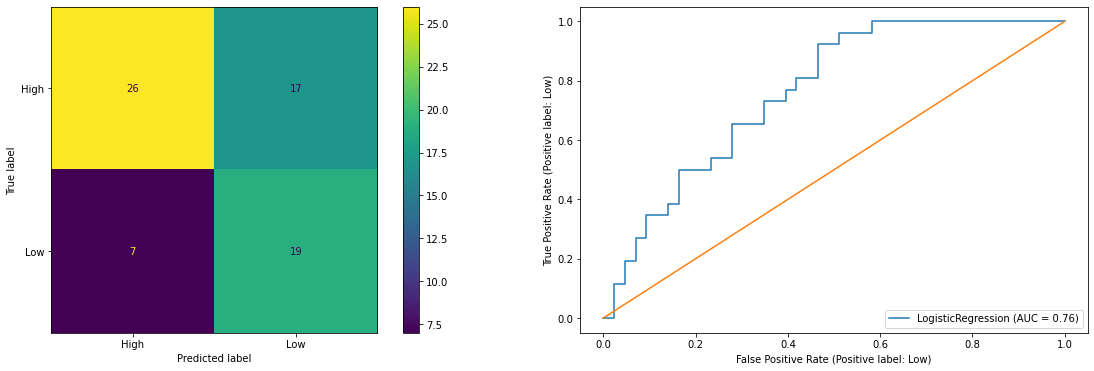

In [47]:
# print the tuned Logistic Regression score and the classification report
print('Logistic Regression tuned score is:', lgr_tun.score(X_test, y_test),'\n')
print(
    f"Classification report for classifier {lgr_tun}:\n"
    f"{metrics.classification_report(y_test, lgr_tun.predict(X_test))}\n");

#print the confusion matrix and the ROC curve
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(lgr_tun, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(lgr_tun, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]));

KNN tuned score is: 0.5942028985507246 

Classification report for classifier KNeighborsClassifier():
              precision    recall  f1-score   support

        High       0.71      0.58      0.64        43
         Low       0.47      0.62      0.53        26

    accuracy                           0.59        69
   macro avg       0.59      0.60      0.59        69
weighted avg       0.62      0.59      0.60        69




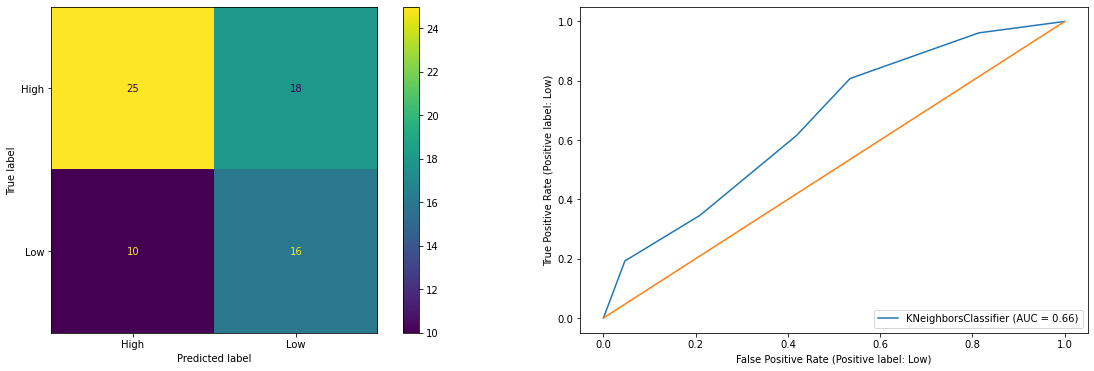

In [48]:
# print the tuned KNN score and the classification report
print('KNN tuned score is:', knn_tun.score(X_test, y_test),'\n')
print(
    f"Classification report for classifier {knn_tun}:\n"
    f"{metrics.classification_report(y_test, knn_tun.predict(X_test))}\n");

#print the confusion matrix and the ROC curve
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(knn_tun, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(knn_tun, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]));

Decision Tree tuned score is: 0.7681159420289855 

Classification report for classifier DecisionTreeClassifier(criterion='entropy', max_depth=50, min_samples_leaf=2,
                       min_samples_split=10):
              precision    recall  f1-score   support

        High       0.78      0.88      0.83        43
         Low       0.75      0.58      0.65        26

    accuracy                           0.77        69
   macro avg       0.76      0.73      0.74        69
weighted avg       0.77      0.77      0.76        69




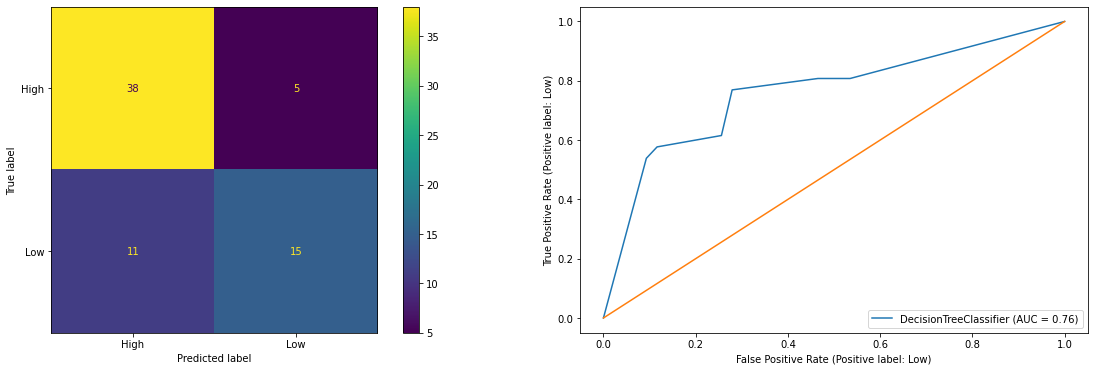

In [49]:
# print the tuned DecisionTree score and the classification report
print('Decision Tree tuned score is:', dtr_tun.score(X_test, y_test),'\n')
print(
    f"Classification report for classifier {dtr_tun}:\n"
    f"{metrics.classification_report(y_test, dtr_tun.predict(X_test))}\n");

#print the confusion matrix and the ROC curve
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(dtr_tun, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(dtr_tun, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]));

SVC tuned score is: 0.6956521739130435 

Classification report for classifier SVC(gamma=0.1):
              precision    recall  f1-score   support

        High       0.84      0.63      0.72        43
         Low       0.57      0.81      0.67        26

    accuracy                           0.70        69
   macro avg       0.71      0.72      0.69        69
weighted avg       0.74      0.70      0.70        69




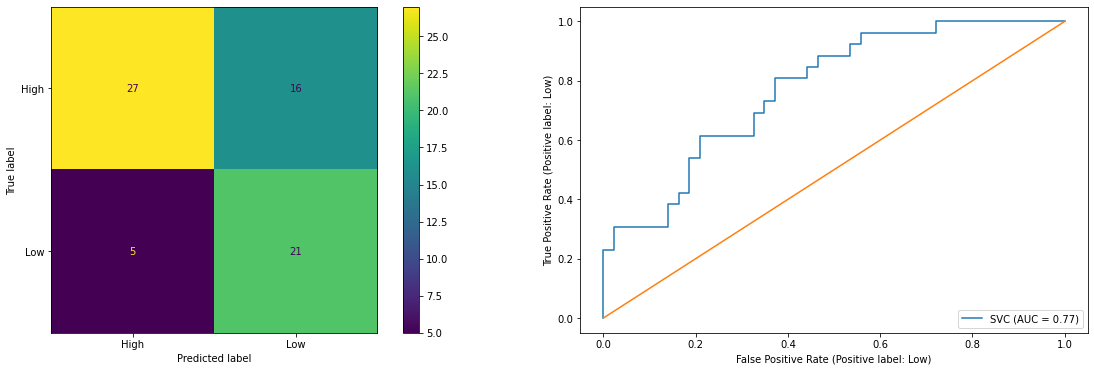

In [50]:
# print the tuned SVC score and the classification report
print('SVC tuned score is:', svc_tun.score(X_test, y_test),'\n')
print(
    f"Classification report for classifier {svc_tun}:\n"
    f"{metrics.classification_report(y_test, svc_tun.predict(X_test))}\n");

#print the confusion matrix and the ROC curve
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(svc_tun, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(svc_tun, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]));

#### Explore the features importance

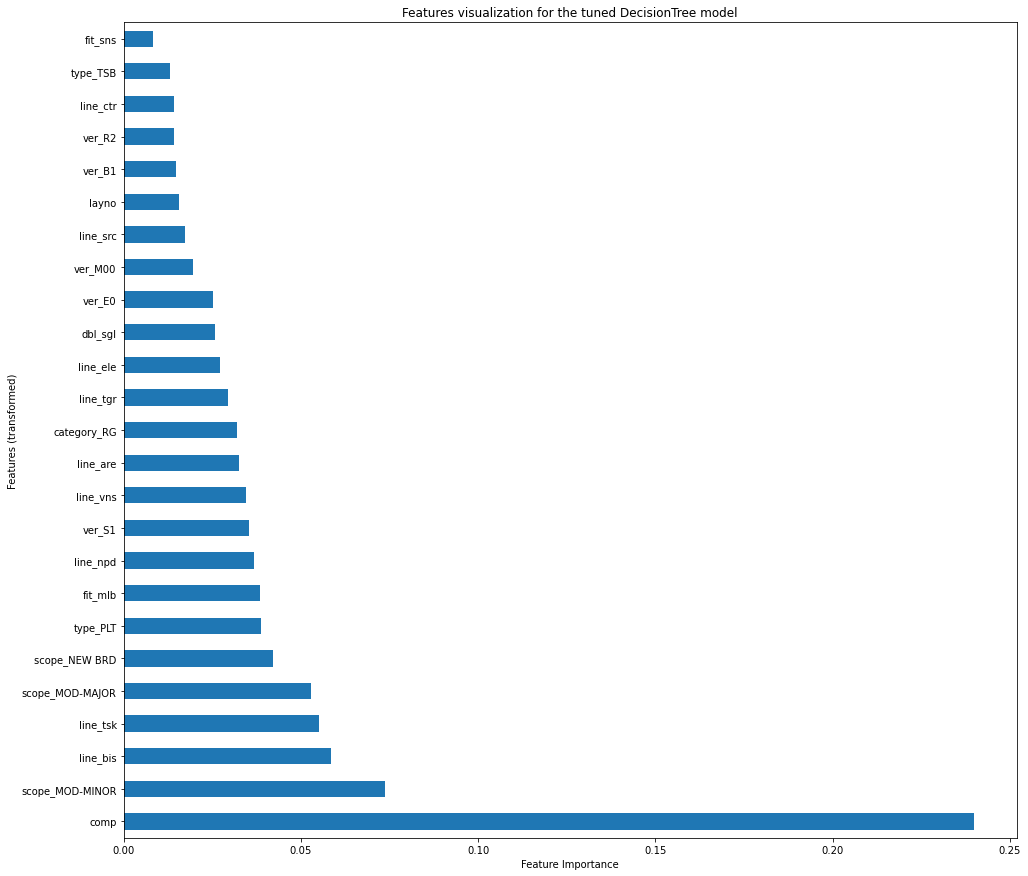

In [51]:
pipe_dtr = Pipeline([('transformer', col_transformer),
            ('model', dtr_tun)])
pipe_dtr.fit(Xi_train, y_train)
plt.figure(figsize = (16,15))
plt.title("Features visualization for the tuned DecisionTree model")
plt.ylabel("Features (transformed)")
plt.xlabel("Feature Importance")
feature_names = pipe_dtr[:-1].get_feature_names_out() 
features_clean = [i.split('__')[-1] for i in feature_names]
feat = pd.Series(
    pipe_dtr[-1].feature_importances_,    
    index=features_clean
)
feat.nlargest(25).plot(kind='barh');

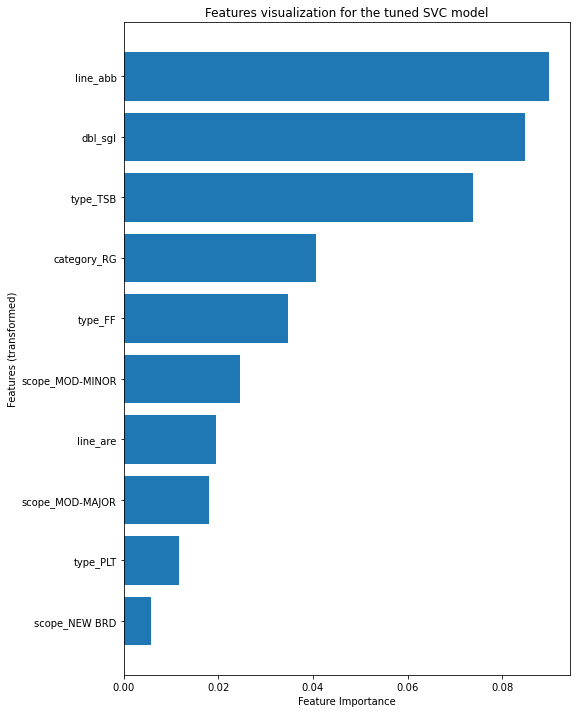

In [52]:
from sklearn.inspection import permutation_importance
pipe_svc = Pipeline([('transformer', col_transformer),
            ('model', svc_tun)])
pipe_svc.fit(Xi_train, y_train)
plt.figure(figsize = (8,12))
plt.title("Features visualization for the tuned SVC model")
plt.ylabel("Features (transformed)")
plt.xlabel("Feature Importance")

perm_importance = permutation_importance(pipe_svc, Xi_train, y_train)

feature_names = pipe_svc[:-1].get_feature_names_out() 
features_clean = [i.split('__')[-1] for i in feature_names]

#feature_names = []
features = np.array(features_clean)

sort = perm_importance.importances_mean.argsort()
plt.barh(features[sort], perm_importance.importances_mean[sort]);

### Conclusions
1. Even if the labels in this dataset are reasonable blanced, the models can classify with a limited precision and with room for improvement
2. The dataset does not have too many entries which limits the training of the models. Also, the determination of the complexity as captured in the dataset was definitely biased, being based on estimation made by engineers or managers, based on subjective factors.
3. More data collected, plus a classifications made based on project characteristics, will improve the dataset in the future, giving a better training to the models. 
4. The dataset and the models cannot capture the unexpected factors which affect the difficulty of a design along the way. A design can start as low complexity based on the initial and change at some point to a highly complex one, in which case the user may update the label, even if the features say otherwise, thus biasing the data.
5. The classification model can be used as an indicator or a pure estimation, useful for the business purpose of assigning resources. 
6. AUC and Precision have been used as model performance criteria. All models performed better than the baseline. 
7. The best models are DecisionTree and SVC, with tuned parameters. 

#### Answers to the initial data task:

1. Can I use the available data to build a classifier tool that can help predicting the complexity of a project?
    * Yes, the data is reasonable
2. What data can be ignored, or dropped from the analysis?
    * Ignore all the features which in practice are not available before the project is done
3. Do I need to clean up the data and how do I prepare the data?
    * Data was clean, preparation included dropping unused columns and encode the data
4. What are the top features that influence the classification?
    * 'comp', 'scope', 'type and 'line' have higher importance
5. Is the model accurate enough? What is missing, how can I improve the data set and the analysis as next steps?
    * with a precision of 0.76 and AUC of 0.77 the model using Decision Tree is reasonable, but there is room for improvement. The first thing missing is more data and some of the next steps are shown below.

#### Overall, through this work, I can provide a reasonable model for classifying projects based on a given set of known characteristics.


### Next steps
1. What can be done to improve the models:
* identify and include additional features which can be collected before the project starts
* collect much more data 
* explore all the available hyperparameters for each model and use larger ranges for the parameters values
* explore other ways to encode the data
* use even fewer features, limit for example to 'comp', 'scope' and 'type' and explore the results
2. What to advise the organization?
* collect more data, hystorical or as becomes available and reach out to similar organizations for data
* use the classification model with the knowledge that it has a limited precision and can be used in conjunction with human input
3. How to use this models in practice?
* integrate the models in a practical classification application with an easy to use GUI 